In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, ConfusionMatrixDisplay
import string
import re
import emoji
import unicodedata
import ftfy

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam, AdamW

from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

import pickle

from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
PATH="../data/sms_spam_indo.csv"
df = pd.read_csv(PATH)

In [3]:
def summary(df):
  print(f'Shape: {df.shape}')

  print(f'\nFeatures:')
  for i, col in enumerate(df.columns):
      print(f'  {i+1}. {col}')
  print()

  print("Summary: ")

  summ = pd.DataFrame({
     'Dtype': df.dtypes,
     'Total Missing': df.isnull().sum(),
     'Total Missing (%)': df.isnull().sum() / len(df) * 100,
      'Unique Values': df.nunique(),
  })
  display(summ)

  print('\nSample Data:')
  display(df.sample(5, random_state=42))

summary(df)

Shape: (1143, 2)

Features:
  1. Kategori
  2. Pesan

Summary: 


,Dtype,Total Missing,Total Missing (%),Unique Values
Kategori,object,0,0.0,2
Pesan,object,0,0.0,1142



Sample Data:


,Kategori,Pesan
158,ham,Jd mau kpnnnih? Kekantor ambil form. Balik lg ...
1081,spam,Kemudahan dan Keamanan bisnis TOGEL kini Berbe...
291,ham,Ka aku ga bisa liat kosannya skrg :( soalnya n...
538,spam,"Maaf saya Bu Nur, tanah yang di tanjung api-ap..."
367,ham,Ayam kita menunya banyak bu...ada ayam bakar.k...


In [4]:
print(f'Total Duplicated Values: {df.duplicated().sum()}')

Total Duplicated Values: 1


In [4]:
LABEL="Kategori"

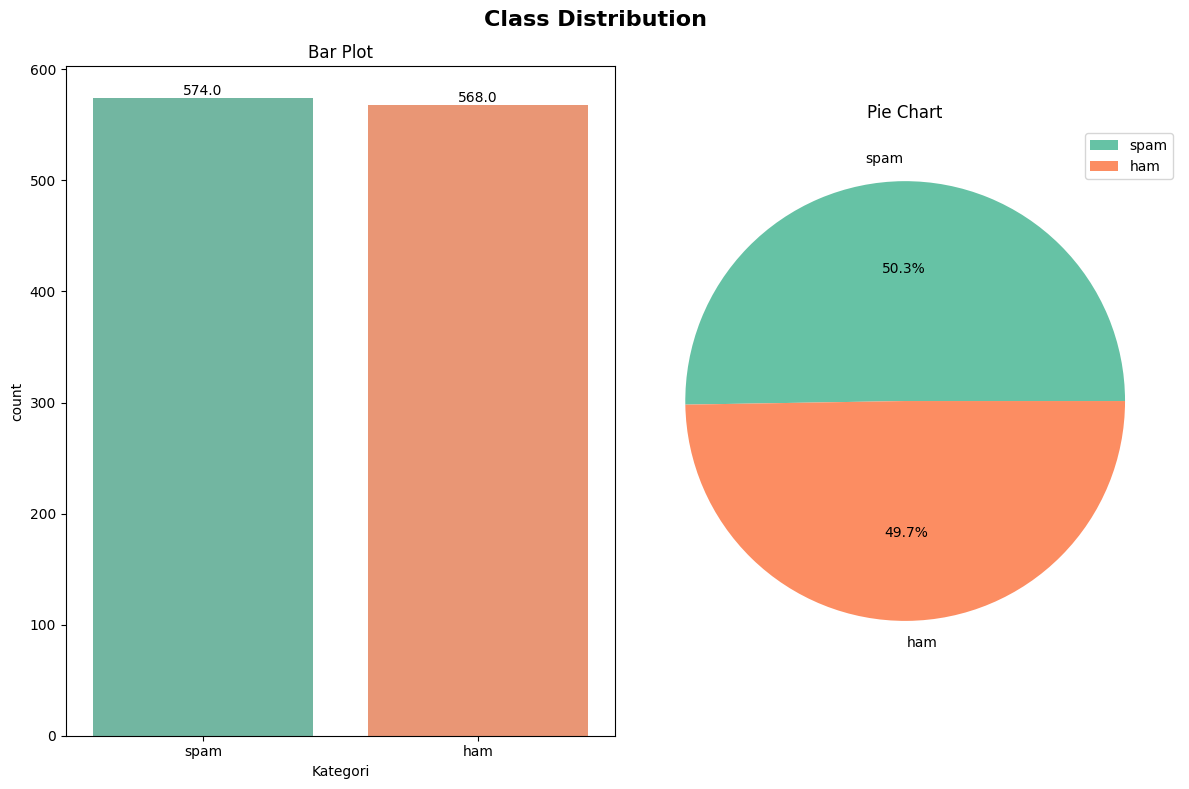

In [29]:
plt.figure(figsize=(12,8))
plt.suptitle('Class Distribution', fontsize=16, fontweight='bold')
plt.subplot(1,2,1)
ax = sns.countplot(data=df, x=LABEL, palette='Set2', order=df[LABEL].value_counts().index)
plt.title('Bar Plot', fontsize=12)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, f'{height}', ha="center", fontsize=10)
plt.subplot(1,2,2)
plt.pie(df[LABEL].value_counts(), labels=df[LABEL].value_counts().index, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
plt.title('Pie Chart', fontsize=12)
plt.tight_layout()
plt.legend()
plt.show()




In [6]:
emoji_pattern = re.compile( "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
print("Total Emojis found in the dataset: ", len(emoji_pattern.findall(" ".join(df['Pesan']))))

Total Emojis found in the dataset:  25


In [7]:
emoji_pattern.findall(" ".join(df['Pesan']))  # display first 10 emojis found

['🙏',
 '😂',
 '😟',
 '😚😚',
 '❤',
 '😂',
 '😊',
 '😂',
 '😆',
 '😂😂',
 '😢',
 '😘',
 '😁',
 '😃😃',
 '😆👍',
 '😭',
 '😂',
 '😊',
 '😂',
 '😂',
 '😂😂',
 '😁',
 '😂',
 '😁',
 '💪']

In [8]:
def demojize_emoji(text):
    emoji_pattern = re.compile(
        "["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE
       )
    
    return emoji_pattern.sub(lambda x: re.sub(r'[\W_]', " ",emoji.demojize(x.group())), text).strip()

text = "I love programming! 😍💻"

# example usage
demojized_text = demojize_emoji(text)
print("Original Text: ", text)
print("Demojized Text: ", demojized_text)


Original Text:  I love programming! 😍💻
Demojized Text:  I love programming!  smiling face with heart eyes  laptop


In [9]:
def normalize_unicode(text):
    text = ftfy.fix_text(text)
    return "".join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)
    )

# example usage
weird_text = "Café 😊 is coöperation naïve fiancé jalapeño año."
normalized_text = normalize_unicode(weird_text)
print("Original Text: ", weird_text)
print("Normalized Text: ", normalized_text)

Original Text:  Café 😊 is coöperation naïve fiancé jalapeño año.
Normalized Text:  Cafe 😊 is cooperation naive fiance jalapeno ano.


In [10]:
def extract_domain_no_suffix(url):
    match = re.search(r'(?:https?:\/\/)?(?:www\.)?([^\.\/]+)', url)
    return match.group(1) if match else None

example_url = "http://www.example.com/path/to/page"
domain = extract_domain_no_suffix(example_url)
print("Example URL: ", example_url)
print("Extracted Domain (no suffix): ", domain)

Example URL:  http://www.example.com/path/to/page
Extracted Domain (no suffix):  example


In [11]:
def cleaned_text(text):
    text = text.lower()
    text = demojize_emoji(text)
    text = normalize_unicode(text)

    slang_dict={
        "ga": "tidak",
        "gak": "tidak",
        "yg": "yang",
        "dgn": "dengan",
        "dg": "dengan",
        "klo": "kalau",
        "kalo": "kalau",
        "tdk": "tidak",
        "tlg": "tolong",
        "jgn": "jangan",
        "sdh": "sudah",
        "sbg": "sebagai",
        "bgt": "banget",
        "kmrn": "kemarin",
        "skrg":  "sekarang",
        "smoga": "semoga",
        "sy": "saya",
        "hrs": "harus",
        "dlm": "dalam",
        "ttp": "tetap",
        "krn": "karena",
        "dr": "dari",
        "pdhl": "padahal",
        "jd": "jadi",
        "aja": "saja",
        "ak": "saya",
        "gw": "saya",
        "lu": "kamu",
        "lo": "kamu",
        "gua": "saya",
        "dpt": "dapat",
        "bbrp": "beberapa",
        "gtw": "gatau",
        "gtau":"gatau",
        "gatau": "tidak tahu",
        "kpn": "kapan",
        "jt": "juta",
        "rb": "ribu",
        "hr": "hari",

    }

    for slang, formal in slang_dict.items():
        text = re.sub(rf'\b{slang}\b', formal, text)

    # take domain names 
    text = re.sub(r'http\S+|www\S+|https\S+', lambda x: extract_domain_no_suffix(x.group()), text, flags=re.MULTILINE)


    text = re.sub(rf'[{string.punctuation}]', ' ', text)
    text = re.sub(r"(.)\1{2,}", r"\1", text)  # reduce repeated characters to two
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(f'[\n\r\t]', ' ', text)
    return text.strip()

df['cleaned_text'] = df['Pesan'].apply(cleaned_text)
df.head()
    

,Kategori,Pesan,cleaned_text
0,spam,Plg Yth: Simcard anda mendptkan bonus poin plu...,plg yth simcard anda mendptkan bonus poin plus...
1,ham,Iya ih ko sedih sih gtau kapan lg ke bandung :(,iya ih ko sedih sih tidak tahu kapan lg ke ban...
2,ham,Kalau mau bikin model/controller mending per a...,kalau mau bikin model controller mending per a...
3,ham,Selamat nama1. Semoga selalu menempuh hidup ya...,selamat nama semoga selalu menempuh hidup yang...
4,spam,Tingkatkan nilai isi ulang Anda selanjutnya mi...,tingkatkan nilai isi ulang anda selanjutnya mi...


In [12]:
sample_text = df['Pesan'].sample(5).tolist()
print("Random tweet text: ")
for i, text in enumerate(sample_text, 1):
  print(f"{i}: {text}")

cleaned_sample = [cleaned_text(t) for t in sample_text]
print("Random cleaned tweet text: ")
for i, text in enumerate(cleaned_sample, 1):
  print(f"{i}: {text}")

Random tweet text: 
1: Jd mau kpnnnih? Kekantor ambil form. Balik lg ngasih laporan atau sekaligus. Jd di laporan ga ada lampiran
2: Kemudahan dan Keamanan bisnis TOGEL kini Berbentuk online, Bergabung dan raih keberuntungan anda di www.brotogel6.com Satu-satunya situs togel online terpercaya
3: Ka aku ga bisa liat kosannya skrg :( soalnya ngerjain uts take home ka 
4: Maaf saya Bu Nur, tanah yang di tanjung api-api saya sudah lihat dan sudah cocok, untuk masalah harga tolong hubungi suami saya aja, pak H.SULAIMAN di no hp. 08xxxxxx, karena kebetulan saya ada acara.Tks
5: Ayam kita menunya banyak bu...ada ayam bakar.kremes. cabe ijo. Lada hitam. Asam manis. Rica rica. Baberque. Untuk isinya nasi.ayam.lalapan.sambal. tempe tahu . air mineral gelas. Bu...maaf bu kita ada paket yang 16rb s/d 19rb. Kalau boleh tau anggaran ibu berapa ya
Random cleaned tweet text: 
1: jadi mau kpnih kekantor ambil form balik lg ngasih laporan atau sekaligus jadi di laporan tidak ada lampiran
2: kemudahan da

In [36]:
stopwords = set(stopwords.words('indonesian'))
sastrawi_factory = StopWordRemoverFactory()
stopword_remover = set(sastrawi_factory.get_stop_words())
STOPWORDS = stopwords.union(stopword_remover)

print(f'Total Stopwords: {len(STOPWORDS)}')


Total Stopwords: 815


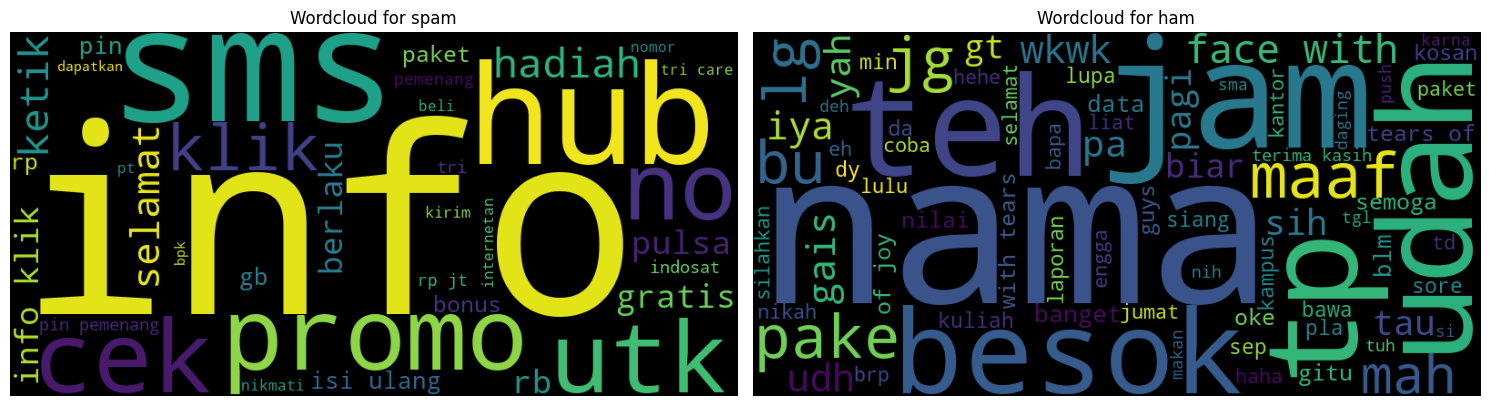

In [63]:
from wordcloud import WordCloud

def wordcloud_plot(df, LABEL):
  label_unique = df[LABEL].unique()
  length = len(label_unique)
  cols = 2
  rows = length // cols + (length % cols > 0)
  plt.figure(figsize=(15, 5 * rows))
  for i, label in enumerate(label_unique, 1):
    plt.subplot(rows, cols, i)
    plt.title(f"Wordcloud for {label}")
    text = " ".join(df[df[LABEL] == label]['cleaned_text'])
    pos_wordcloud = WordCloud(
        background_color='black',
        height=400,
        width=800,
        stopwords=STOPWORDS,
        min_font_size=15
    ).generate(text)
    plt.imshow(pos_wordcloud)
    plt.axis('off')
  plt.tight_layout()
  plt.show

wordcloud_plot(df, LABEL)

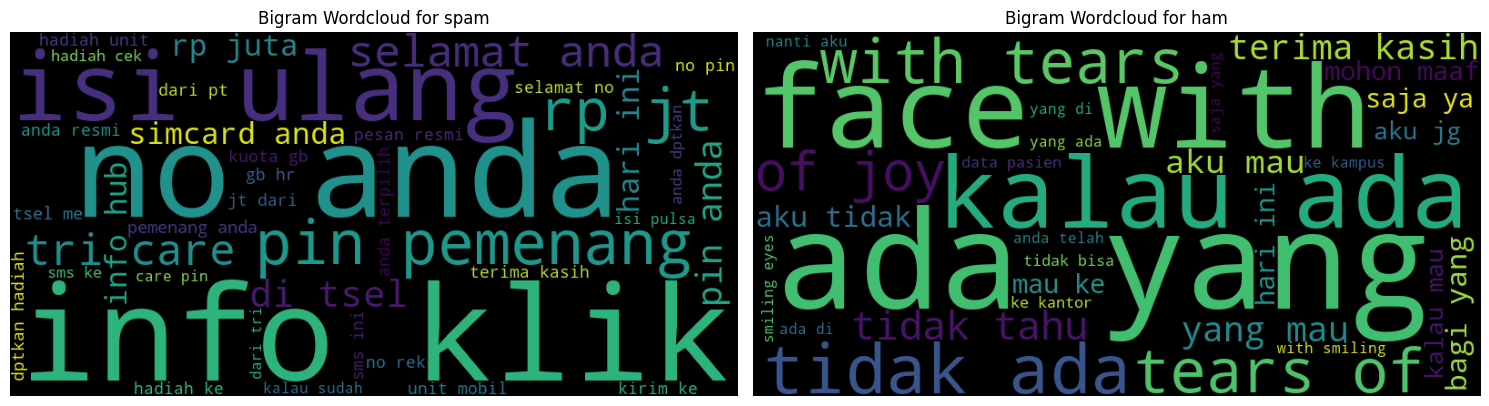

In [66]:
# wordcloud for bigram
def wordcloud_plot_bigram(df, LABEL):
    label_unique = df[LABEL].unique()
    length = len(label_unique)
    cols = 2
    rows = length // cols + (length % cols > 0)
    plt.figure(figsize=(15, 5 * rows))
    for i, label in enumerate(label_unique, 1):
        plt.subplot(rows, cols, i)
        plt.title(f"Bigram Wordcloud for {label}")
        text = df[df[LABEL] == label]['cleaned_text']
        vectorizer = CountVectorizer(ngram_range=(2, 2))
        X = vectorizer.fit_transform(text)
        sum_words = X.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items() if word not in STOPWORDS]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        wordcloud = WordCloud(
            background_color='black',
            height=400,
            width=800,
            min_font_size=15
        ).generate_from_frequencies(dict(words_freq))
        plt.imshow(wordcloud)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
   
wordcloud_plot_bigram(df, LABEL)

In [13]:
df[LABEL] = df[LABEL].map({'ham':0, 'spam':1})

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df[LABEL],
    test_size=0.2,
    random_state=42,
    stratify=df[LABEL]
)


In [16]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

def modeling(X_train, X_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_probs = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_probs)
        results[name] = auc_score
        print(f"{name} - AUC: {auc_score:.4f}")
        print(classification_report(y_test, model.predict(X_test), digits=4))
        cm = confusion_matrix(y_test, model.predict(X_test))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for {name}')
        plt.show()
    return results




## TfIdf 

In [50]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words=list(STOPWORDS))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

RandomForest - AUC: 0.9973
              precision    recall  f1-score   support

           0     0.9573    0.9825    0.9697       114
           1     0.9821    0.9565    0.9692       115

    accuracy                         0.9694       229
   macro avg     0.9697    0.9695    0.9694       229
weighted avg     0.9698    0.9694    0.9694       229



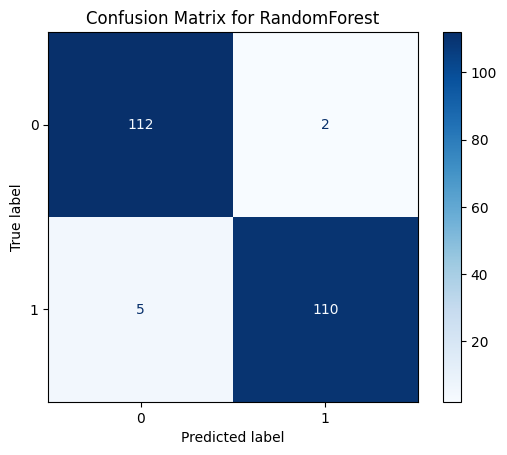

DecisionTree - AUC: 0.9651
              precision    recall  f1-score   support

           0     0.9649    0.9649    0.9649       114
           1     0.9652    0.9652    0.9652       115

    accuracy                         0.9651       229
   macro avg     0.9651    0.9651    0.9651       229
weighted avg     0.9651    0.9651    0.9651       229



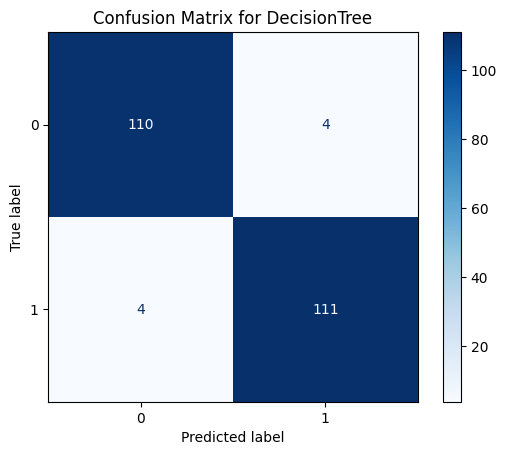

XGBoost - AUC: 0.9890
              precision    recall  f1-score   support

           0     0.9016    0.9649    0.9322       114
           1     0.9626    0.8957    0.9279       115

    accuracy                         0.9301       229
   macro avg     0.9321    0.9303    0.9301       229
weighted avg     0.9323    0.9301    0.9301       229



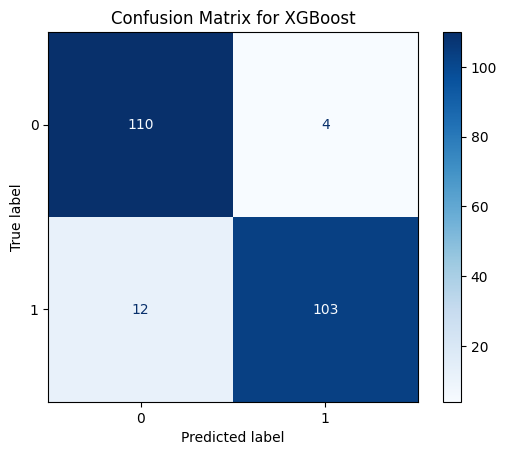

[LightGBM] [Info] Number of positive: 459, number of negative: 455
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1232
[LightGBM] [Info] Number of data points in the train set: 914, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502188 -> initscore=0.008753
[LightGBM] [Info] Start training from score 0.008753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


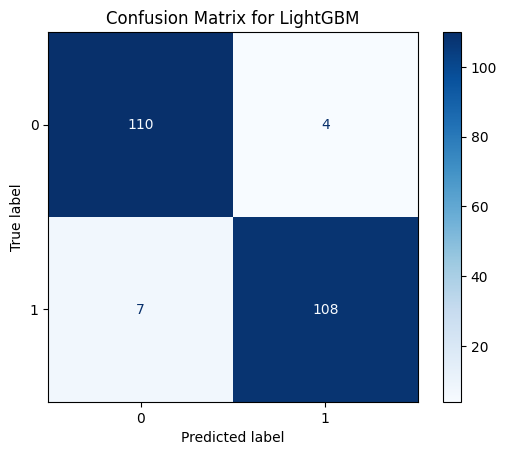

CatBoost - AUC: 0.9973
              precision    recall  f1-score   support

           0     0.9649    0.9649    0.9649       114
           1     0.9652    0.9652    0.9652       115

    accuracy                         0.9651       229
   macro avg     0.9651    0.9651    0.9651       229
weighted avg     0.9651    0.9651    0.9651       229



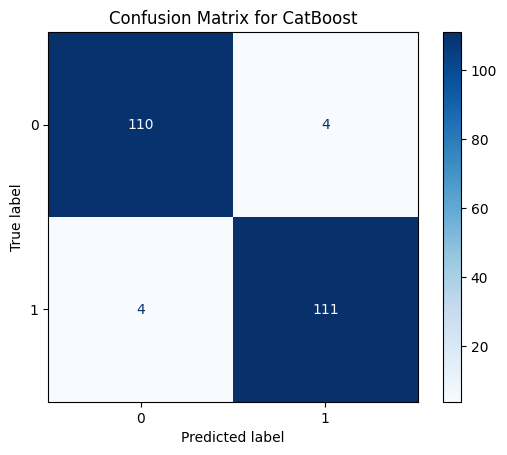

{'RandomForest': 0.997254004576659,
 'DecisionTree': 0.965064836003051,
 'XGBoost': 0.9890160183066361,
 'LightGBM': 0.9790999237223493,
 'CatBoost': 0.997254004576659}

In [51]:
modeling(X_train_tfidf, X_test_tfidf, y_train, y_test, models)

## Sentence Transformer Embedding

In [ ]:
# sentence transformer embedding

model = SentenceTransformer('LazarusNLP/congen-indobert-base')
X_train_st = model.encode(X_train.tolist(), convert_to_tensor=True)
X_test_st = model.encode(X_test.tolist(), convert_to_tensor=True)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


RandomForest - AUC: 0.9768
              precision    recall  f1-score   support

           0     0.9068    0.9386    0.9224       114
           1     0.9369    0.9043    0.9204       115

    accuracy                         0.9214       229
   macro avg     0.9219    0.9215    0.9214       229
weighted avg     0.9219    0.9214    0.9214       229



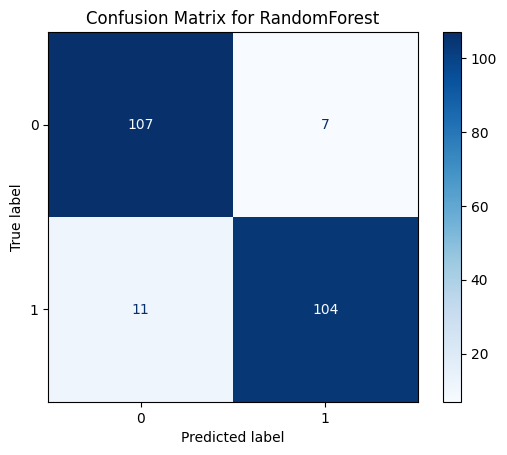

DecisionTree - AUC: 0.8341
              precision    recall  f1-score   support

           0     0.8333    0.8333    0.8333       114
           1     0.8348    0.8348    0.8348       115

    accuracy                         0.8341       229
   macro avg     0.8341    0.8341    0.8341       229
weighted avg     0.8341    0.8341    0.8341       229



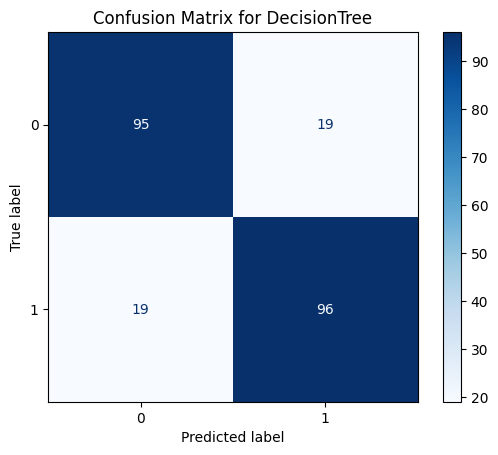

XGBoost - AUC: 0.9795
              precision    recall  f1-score   support

           0     0.9310    0.9474    0.9391       114
           1     0.9469    0.9304    0.9386       115

    accuracy                         0.9389       229
   macro avg     0.9390    0.9389    0.9389       229
weighted avg     0.9390    0.9389    0.9389       229



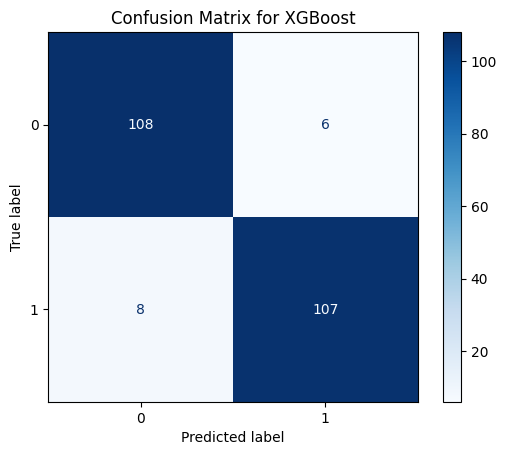

[LightGBM] [Info] Number of positive: 459, number of negative: 455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 914, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502188 -> initscore=0.008753
[LightGBM] [Info] Start training from score 0.008753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM - AUC: 0.9817
              precision    recall  f1-score   support

           0     0.9244    0.9649    0.9442       114
           1     0.9636    0.9217    0.9422       115

    accuracy                         0.9432       229
   macro avg     0.9440    0.9433    0.9432       229
weighted avg     0.9441    0.9432    0.9432       229



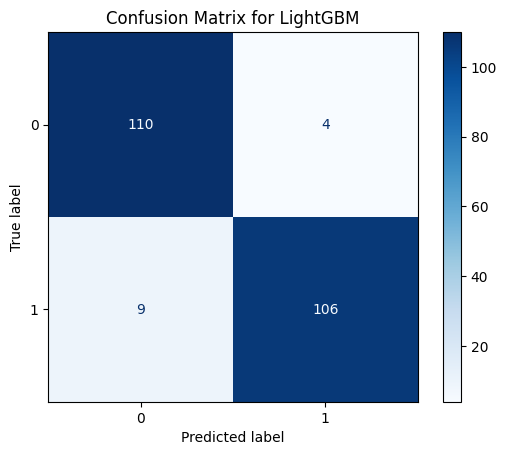

CatBoost - AUC: 0.9793
              precision    recall  f1-score   support

           0     0.9304    0.9386    0.9345       114
           1     0.9386    0.9304    0.9345       115

    accuracy                         0.9345       229
   macro avg     0.9345    0.9345    0.9345       229
weighted avg     0.9345    0.9345    0.9345       229



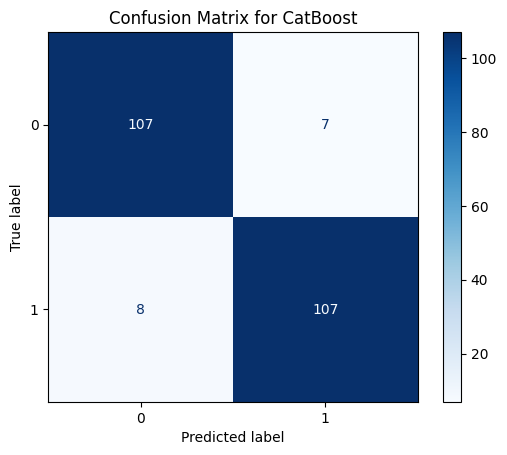

{'RandomForest': 0.9768497330282228,
 'DecisionTree': 0.8340579710144929,
 'XGBoost': 0.9794813119755912,
 'LightGBM': 0.9816933638443935,
 'CatBoost': 0.9792524790236461}

In [55]:
X_train_st = X_train_st.numpy()
X_test_st = X_test_st.numpy()

modeling(X_train_st, X_test_st, y_train, y_test, models)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


RandomForest - AUC: 0.9813
              precision    recall  f1-score   support

           0     0.8992    0.9386    0.9185       114
           1     0.9364    0.8957    0.9156       115

    accuracy                         0.9170       229
   macro avg     0.9178    0.9171    0.9170       229
weighted avg     0.9178    0.9170    0.9170       229



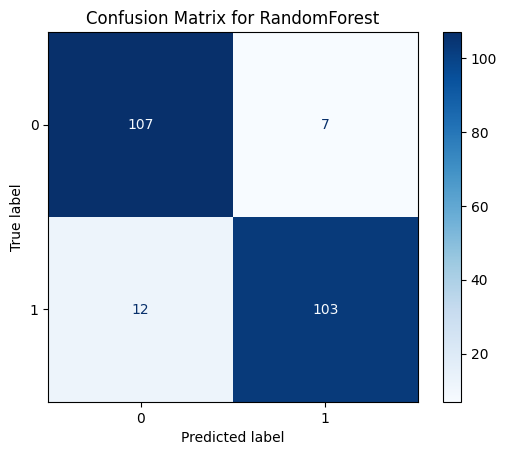

DecisionTree - AUC: 0.8605
              precision    recall  f1-score   support

           0     0.8306    0.9035    0.8655       114
           1     0.8952    0.8174    0.8545       115

    accuracy                         0.8603       229
   macro avg     0.8629    0.8605    0.8600       229
weighted avg     0.8631    0.8603    0.8600       229



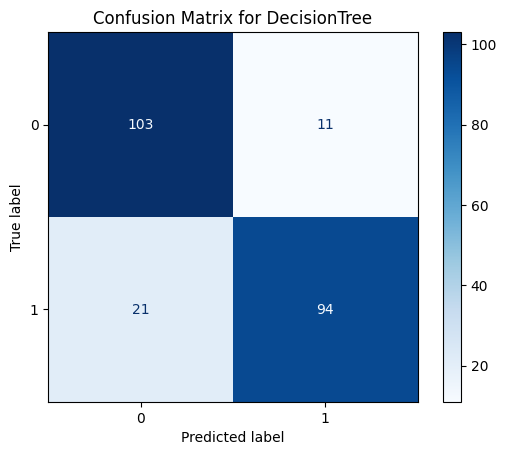

XGBoost - AUC: 0.9873
              precision    recall  f1-score   support

           0     0.9244    0.9649    0.9442       114
           1     0.9636    0.9217    0.9422       115

    accuracy                         0.9432       229
   macro avg     0.9440    0.9433    0.9432       229
weighted avg     0.9441    0.9432    0.9432       229



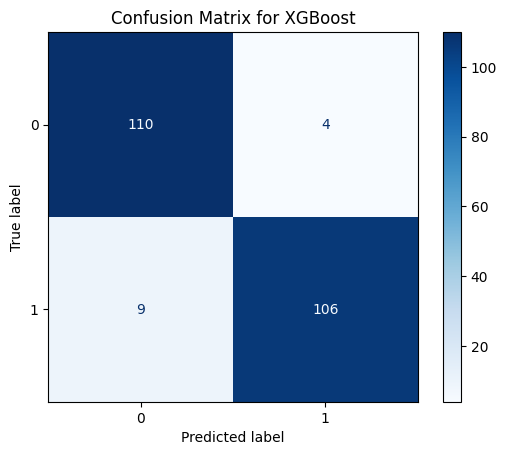

[LightGBM] [Info] Number of positive: 459, number of negative: 455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 914, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502188 -> initscore=0.008753
[LightGBM] [Info] Start training from score 0.008753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM - AUC: 0.9871
              precision    recall  f1-score   support

           0     0.9391    0.9474    0.9432       114
           1     0.9474    0.9391    0.9432       115

    accuracy                         0.9432       229
   macro avg     0.9432    0.9432    0.9432       229
weighted avg     0.9433    0.9432    0.9432       229



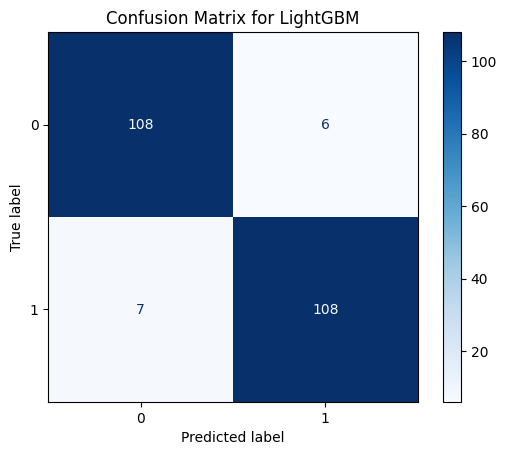

CatBoost - AUC: 0.9867
              precision    recall  f1-score   support

           0     0.9076    0.9474    0.9270       114
           1     0.9455    0.9043    0.9244       115

    accuracy                         0.9258       229
   macro avg     0.9265    0.9259    0.9257       229
weighted avg     0.9266    0.9258    0.9257       229



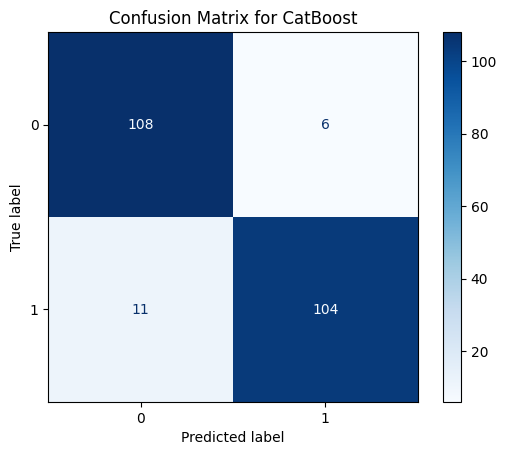

{'RandomForest': 0.9813119755911518,
 'DecisionTree': 0.8604500381388254,
 'XGBoost': 0.9873379099923723,
 'LightGBM': 0.9871090770404272,
 'CatBoost': 0.9867276887871854}

In [58]:
# sentence transformer embedding

model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
X_train_st = model.encode(X_train.tolist(), convert_to_tensor=True)
X_test_st = model.encode(X_test.tolist(), convert_to_tensor=True)
X_train_st = X_train_st.numpy()
X_test_st = X_test_st.numpy()
modeling(X_train_st, X_test_st, y_train, y_test, models)

## Embedding word2vec - fine tuning and evaluation

```python

In [17]:
# fine tune word2vec model

w2v_model = Word2Vec(vector_size=300, window=5, min_count=2, workers=4, sg=1)
tokenized_sentences = [simple_preprocess(text) for text in X_train]
w2v_model.build_vocab(tokenized_sentences)
w2v_model.train(tokenized_sentences, total_examples=w2v_model.corpus_count, epochs=100)

(1043848, 1488800)

In [ ]:
word2vec_weights = w2v_model.wv.vectors

word2vec_weights

array([[-0.20455717,  0.07832604, -0.06771959, ..., -0.46070132,
        -0.17596993, -0.06332489],
       [-0.3060791 ,  0.40393302,  0.07089677, ..., -0.24974236,
         0.01245318, -0.11725146],
       [-0.17841274,  0.17747886, -0.02104241, ...,  0.02661596,
         0.15618195, -0.01041351],
       ...,
       [-0.05890019, -0.21045437, -0.07550013, ...,  0.02775112,
         0.1234226 ,  0.16905573],
       [-0.05061961,  0.15081677,  0.30566102, ..., -0.10078135,
         0.29687113, -0.14189571],
       [-0.34449226,  0.10723437, -0.2151084 , ...,  0.05780793,
         0.12639491,  0.03172143]], dtype=float32)

In [ ]:

w2v_model.wv.most_similar("togel", topn=10)


[('mbah', 0.8505071997642517),
 ('joko', 0.7841867804527283),
 ('kalah', 0.7263309359550476),
 ('hasil', 0.7198721766471863),
 ('tembus', 0.7187759876251221),
 ('kini', 0.7023618221282959),
 ('angka', 0.690708339214325),
 ('kemudahan', 0.6785925626754761),
 ('sering', 0.6603971719741821),
 ('bergabung', 0.6528148055076599)]

In [70]:
w2v_model.save('word2vec.model')

RandomForest - AUC: 0.9926
              precision    recall  f1-score   support

           0     0.9646    0.9561    0.9604       114
           1     0.9569    0.9652    0.9610       115

    accuracy                         0.9607       229
   macro avg     0.9607    0.9607    0.9607       229
weighted avg     0.9607    0.9607    0.9607       229



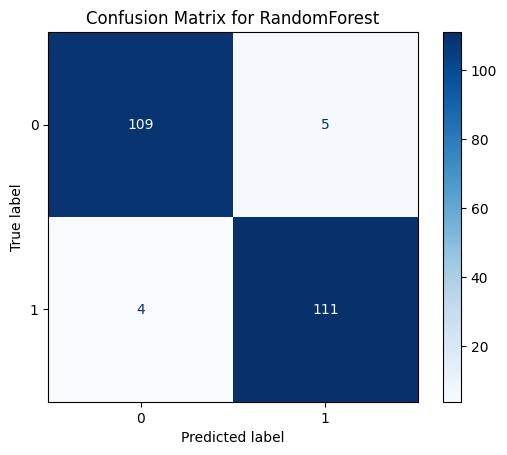

DecisionTree - AUC: 0.9256
              precision    recall  f1-score   support

           0     0.9533    0.8947    0.9231       114
           1     0.9016    0.9565    0.9283       115

    accuracy                         0.9258       229
   macro avg     0.9275    0.9256    0.9257       229
weighted avg     0.9273    0.9258    0.9257       229



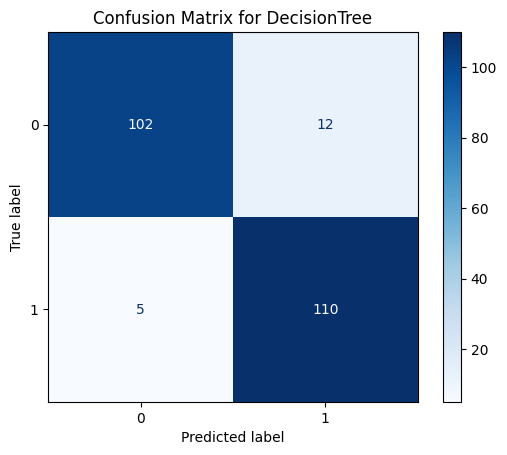

XGBoost - AUC: 0.9933
              precision    recall  f1-score   support

           0     0.9646    0.9561    0.9604       114
           1     0.9569    0.9652    0.9610       115

    accuracy                         0.9607       229
   macro avg     0.9607    0.9607    0.9607       229
weighted avg     0.9607    0.9607    0.9607       229



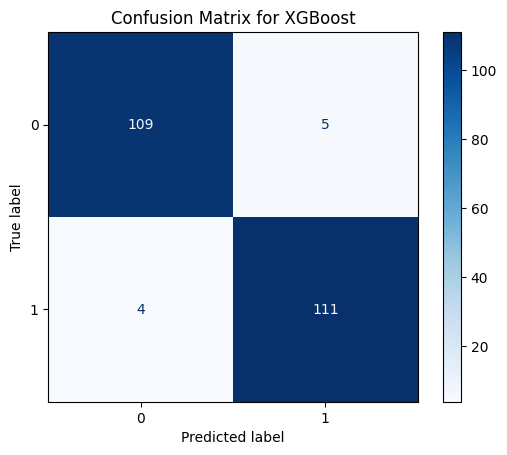

[LightGBM] [Info] Number of positive: 459, number of negative: 455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76498
[LightGBM] [Info] Number of data points in the train set: 914, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502188 -> initscore=0.008753
[LightGBM] [Info] Start training from score 0.008753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM - AUC: 0.9928
              precision    recall  f1-score   support

           0     0.9730    0.9474    0.9600       114
           1     0.9492    0.9739    0.9614       115

    accuracy                         0.9607       229
   macro avg     0.9611    0.9606    0.9607       229
weighted avg     0.9610    0.9607    0.9607       229



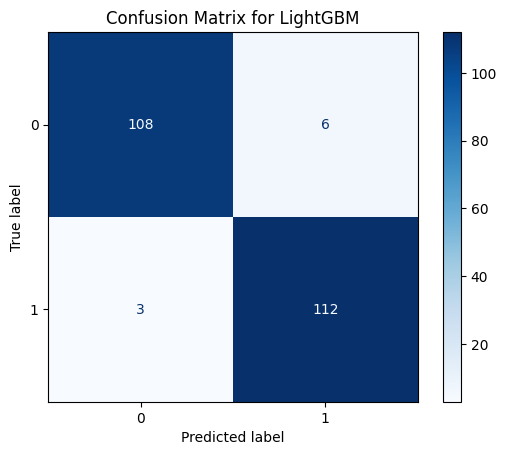

CatBoost - AUC: 0.9920
              precision    recall  f1-score   support

           0     0.9735    0.9649    0.9692       114
           1     0.9655    0.9739    0.9697       115

    accuracy                         0.9694       229
   macro avg     0.9695    0.9694    0.9694       229
weighted avg     0.9695    0.9694    0.9694       229



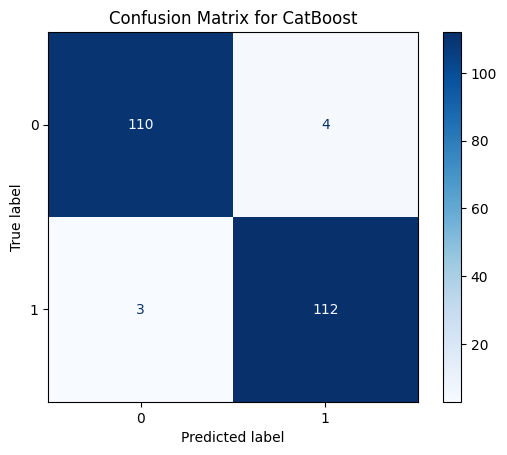

{'RandomForest': 0.9926392067124332,
 'DecisionTree': 0.9256292906178489,
 'XGBoost': 0.9932875667429443,
 'LightGBM': 0.9927536231884058,
 'CatBoost': 0.9919908466819223}

In [ ]:
def vectorize_text_w2v(texts, model, vector_size):
    vectors = []
    for text in texts:
        tokens = simple_preprocess(text)
        word_vectors = [model.wv[word] for word in tokens if word in model.wv]
        if word_vectors:
            text_vector = np.mean(word_vectors, axis=0)
        else:
            text_vector = np.zeros(vector_size)
        vectors.append(text_vector)
    return np.array(vectors)

w2v_model = Word2Vec.load('../assets/word2vec.model')

X_train_w2v = vectorize_text_w2v(X_train, w2v_model, 300)
X_test_w2v = vectorize_text_w2v(X_test, w2v_model, 300)
modeling(X_train_w2v, X_test_w2v, y_train, y_test, models)

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print(f'Vocabulary Size: {vocab_size}')
print(f'Dictionary Sample: {dict(list(word_index.items())[:10])}')

Vocabulary Size: 3519
Dictionary Sample: {'di': 1, 'anda': 2, 'info': 3, 'ke': 4, 'yang': 5, 'dari': 6, 'ini': 7, 'pin': 8, 'no': 9, 'rp': 10}


In [94]:
# save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [20]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = 100

X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

embedding_dim = 300

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
embedding_matrix.shape

(3519, 300)

In [81]:
def create_lstm_model(vocab_size, embedding_dim, max_length, embedding_matrix):
    inputs = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=True)(inputs)
    lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
    lstm_layer2 = Bidirectional(LSTM(64, return_sequences=False))(lstm_layer)
    dropout_layer = Dropout(0.2)(lstm_layer2)
    Dense_layer = Dense(32, activation='relu')(dropout_layer)
    dropout_layer2 = Dropout(0.2)(Dense_layer)
    dense_layer2 = Dense(16, activation='relu')(dropout_layer2)
    outputs = Dense(1, activation='sigmoid')(dense_layer2)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc')])
    return model
    

model = create_lstm_model(vocab_size, embedding_dim, max_length, embedding_matrix)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 100, 300)       │     1,055,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 100, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,664,021 (6.35 MB)

 Trainable params: 1,664,021 (6.35 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, verbose=1, mode='max', min_lr=1e-6)
es = EarlyStopping(monitor='val_auc', patience=7, verbose=1, mode='max', restore_best_weights=True)
mc = ModelCheckpoint('best_lstm_model.h5', monitor='val_auc', mode='max', save_best_only=True, verbose=1)
history = model.fit(
    X_train_padded,
    y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr, es, mc]
)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8118 - auc: 0.9040 - loss: 0.4522
Epoch 1: val_auc improved from None to 0.97872, saving model to best_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 25s 502ms/step - accuracy: 0.9015 - auc: 0.9562 - loss: 0.3048 - val_accuracy: 0.9290 - val_auc: 0.9787 - val_loss: 0.2451 - learning_rate: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9766 - auc: 0.9756 - loss: 0.1241
Epoch 2: val_auc improved from 0.97872 to 0.98112, saving model to best_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 628ms/step - accuracy: 0.9795 - auc: 0.9813 - loss: 0.1080 - val_accuracy: 0.9290 - val_auc: 0.9811 - val_loss: 0.2126 - learning_rate: 0.0010
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.9773 - auc: 0.9935 - loss: 0.0810
Epoch 3: val_auc improved from 0.98112 to 0.98454, saving model to best_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 509ms/step - accuracy: 0.9740 - auc: 0.9932 - loss: 0.0869 - val_accuracy: 0.9727 - val_auc: 0.9845 - val_loss: 0.1153 - learning_rate: 0.0010
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9857 - auc: 0.9934 - loss: 0.0650
Epoch 4: val_auc improved from 0.98454 to 0.98981, saving model to best_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step - accuracy: 0.9877 - auc: 0.9973 - loss: 0.0507 - val_accuracy: 0.9672 - val_auc: 0.9898 - val_loss: 0.1027 - learning_rate: 0.0010
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9877 - auc: 0.9993 - loss: 0.0351
Epoch 5: val_auc improved from 0.98981 to 0.99161, saving model to best_lstm_model.h5


23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 384ms/step - accuracy: 0.9891 - auc: 0.9992 - loss: 0.0382 - val_accuracy: 0.9672 - val_auc: 0.9916 - val_loss: 0.1080 - learning_rate: 0.0010
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9885 - auc: 0.9998 - loss: 0.0308
Epoch 6: val_auc did not improve from 0.99161
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 373ms/step - accuracy: 0.9945 - auc: 0.9999 - loss: 0.0198 - val_accuracy: 0.9399 - val_auc: 0.9831 - val_loss: 0.2034 - learning_rate: 0.0010
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.9927 - auc: 0.9999 - loss: 0.0240
Epoch 7: val_auc did not improve from 0.99161
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 394ms/step - accuracy: 0.9973 - auc: 0.9999 - loss: 0.0122 - val_accuracy: 0.9399 - val_auc: 0.9823 - val_loss: 0.2472 - learning_rate: 0.0010
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0024
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 8: val

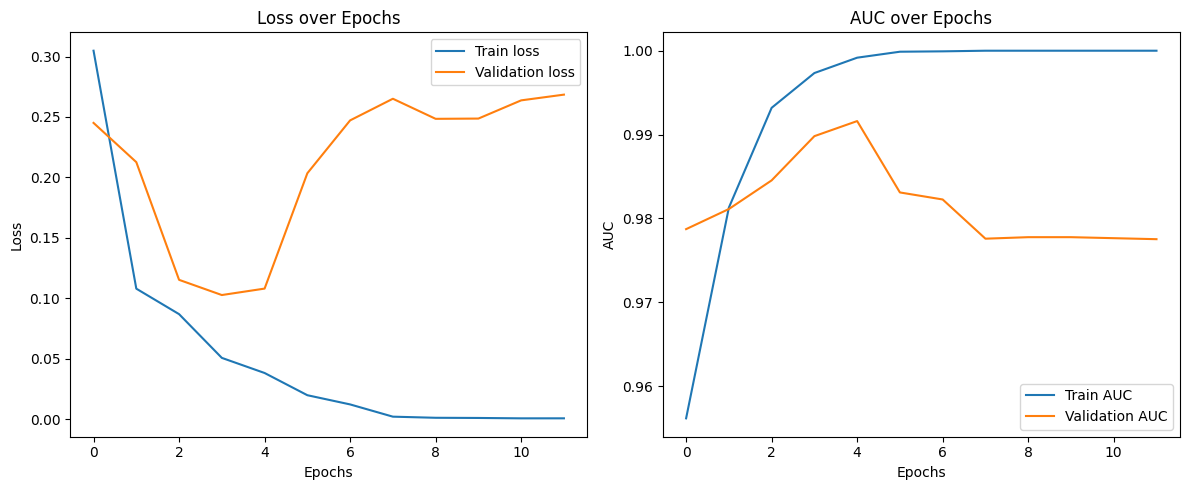

In [83]:
def plot_history(hist):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Train loss')
    plt.plot(hist.history['val_loss'], label='Validation loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['auc'], label='Train AUC')
    plt.plot(hist.history['val_auc'], label='Validation AUC')
    plt.title('AUC over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)

In [84]:
model.evaluate(X_test_padded, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - accuracy: 0.9825 - auc: 0.9985 - loss: 0.0563


[0.05633045360445976, 0.9825327396392822, 0.9985126256942749]

In [87]:
y_probs = model.predict(X_test_padded)
print(f'AUC: {roc_auc_score(y_test, y_probs):.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step
AUC: 0.9985


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 535ms/step
              precision    recall  f1-score   support

           0     0.9911    0.9737    0.9823       114
           1     0.9744    0.9913    0.9828       115

    accuracy                         0.9825       229
   macro avg     0.9827    0.9825    0.9825       229
weighted avg     0.9827    0.9825    0.9825       229



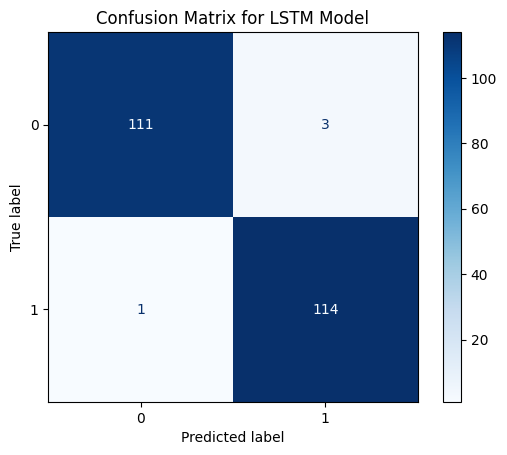

In [85]:
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [91]:
# tuning lstm model
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    inputs = Input(shape=(max_length,))
    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=True)(inputs)
    lstm_units = hp.Int('lstm_units', min_value=64, max_value=256, step=32)
    lstm_layer = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
    lstm_layer2 = Bidirectional(LSTM(lstm_units//2, return_sequences=False))(lstm_layer)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    dropout_layer = Dropout(dropout_rate)(lstm_layer2)
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        dense_units = hp.Int(f'dense_units_{i}', min_value=16, max_value=128, step=16)
        dense_layer = Dense(dense_units, activation='relu')(dropout_layer)
        dropout_layer = Dropout(dropout_rate)(dense_layer)
    outputs = Dense(1, activation='sigmoid')(dropout_layer)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = AdamW(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]), weight_decay=1e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

tuner = RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=5,
    executions_per_trial=2,
    directory='lstm_tuning',
    project_name='sms_spam_indonesia'
)

lr = ReduceLROnPlateau(monitor='val_auc', factor=0.5, patience=3, verbose=1, mode='max', min_lr=1e-6)
es = EarlyStopping(monitor='val_auc', patience=7, verbose=1, mode='max', restore_best_weights=True)
tuner.search(X_train_padded, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[lr, es])

Trial 5 Complete [00h 14m 34s]
val_auc: 0.9884620308876038

Best val_auc So Far: 0.9884620308876038
Total elapsed time: 01h 17m 28s


Results summary
Results in lstm_tuning\sms_spam_indonesia
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 4 summary
Hyperparameters:
lstm_units: 256
dropout_rate: 0.5
dense_units: 16
learning_rate: 0.0001
Score: 0.9884620308876038

Trial 1 summary
Hyperparameters:
lstm_units: 224
dropout_rate: 0.2
dense_units: 48
learning_rate: 0.001
Score: 0.9866638779640198

Trial 3 summary
Hyperparameters:
lstm_units: 64
dropout_rate: 0.5
dense_units: 48
learning_rate: 0.001
Score: 0.9857048690319061

Trial 2 summary
Hyperparameters:
lstm_units: 128
dropout_rate: 0.4
dense_units: 48
learning_rate: 0.0001
Score: 0.9839366972446442

Trial 0 summary
Hyperparameters:
lstm_units: 128
dropout_rate: 0.5
dense_units: 48
learning_rate: 0.0001
Score: 0.9809698164463043
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step 
AUC: 0.9971
              precision    recall  f1-score   support

           0     0.9732    0.9561    0.9646       114
           1     0.9573    0.9739    0.9655       115

    a

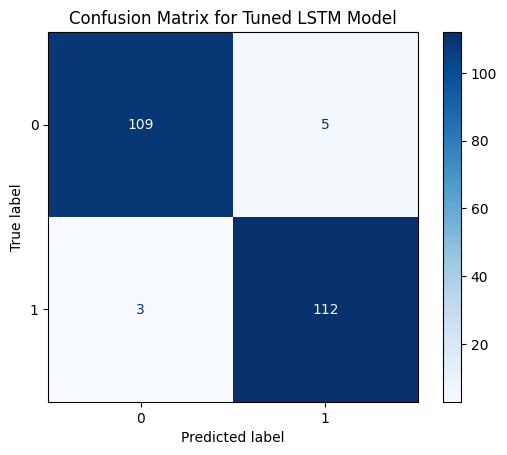

In [92]:
# get best weight from tuning

tuner.results_summary()

# load best weight
best_model = tuner.get_best_models(num_models=1)[0]

y_probs = best_model.predict(X_test_padded)
print(f'AUC: {roc_auc_score(y_test, y_probs):.4f}')
print(classification_report(y_test, (y_probs > 0.5).astype("int32"), digits=4))
cm = confusion_matrix(y_test, (y_probs > 0.5).astype("int32"))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Tuned LSTM Model')
plt.show()

# save best model
best_model.save('best_lstm_tuned_model.h5')

In [32]:
df[df['Kategori'] == 1]['Pesan'].iloc[0]

'Plg Yth: Simcard anda mendptkan bonus poin plus-plus 555 dr:PT.INDOSAT pin anda:277fg49 u/info klik di www.indosat-555.blogspot.com atau Hub:021-3338-0074.'

In [ ]:
model = tf.keras.models.load_model('../assets/best_lstm_model.h5')
texts = ['Iya ih ko sedih sih gtau kapan lg ke bandung :(', 'Plg Yth: Simcard anda mendptkan bonus poin plus-plus 555 dr:PT.INDOSAT pin anda:277fg49 u/info klik di www.indosat-555.blogspot.com atau Hub:021-3338-0074.']
cleaned = [cleaned_text(t) for t in texts]
tokenized = tokenizer.texts_to_sequences(cleaned)
padded = pad_sequences(tokenized, maxlen=max_length, padding='post', truncating='post')
predictions = model.predict(padded)
predictions



1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[5.9095654e-04],
       [9.9850065e-01]], dtype=float32)

In [39]:
text ='Plg Yth: Simcard anda mendptkan bonus poin plus-plus 555 dr:PT.INDOSAT pin anda:277fg49 u/info klik di www.indosat-555.blogspot.com atau Hub:021-3338-0074.'
cleaned = cleaned_text(text)
sequence = tokenizer.texts_to_sequences([cleaned])
padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
y_pred = model.predict(padded)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


array([[0.99850065]], dtype=float32)